# SafeNetAI

The dataset is from Kaggle's [Cyberbullying Classification Dataset](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification)

## 1. Loading Libraries

* **NLTK** is a library for processing the message
* **WordCloud** and matplotlib are for visualization data
* **Pandas** is for loading csv file
* **RE** presents regular expression for finding words with specific patterns
* **Sklearn** is for generating train-test datasets randomly



In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Regular expressions for text preprocessing
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score


# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure plots are displayed inline
%matplotlib inline

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/degerahmet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/degerahmet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Loading data from the cyberbullying_tweets.csv file

In [3]:
df = pd.read_csv('cyberbullying_tweets.csv')

# Display the first few rows of the dataset to verify it's loaded correctly
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## 3. Inspect the data

In [3]:
# Shape of the dataset (rows, columns)
df.shape

(47692, 2)

In [4]:
# Summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
# Basic stats
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [6]:
# Check for missing values
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
# Take a look at the first 20 tweets to get a sense of how we might need to clean the data
pd.set_option('display.max_colwidth', None)
df['tweet_text'].head(20)

0                                                                                  In other words #katandandre, your food was crapilicious! #mkr
1                            Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
2                                                                                   @XochitlSuckkks a classy whore? Or more red velvet cupcakes?
3                                        @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
4                                        @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
5            @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
6                                                                                         Itu sekolah ya bukan tempat bully! Ga ja

In [7]:
# List the unique classification types
list(df['cyberbullying_type'].unique())

['not_cyberbullying',
 'gender',
 'religion',
 'other_cyberbullying',
 'age',
 'ethnicity']

## 4. Clean the tweets
Let's remove usernames, links, special characters, etc. We'll keep the column for the original tweet, and add columns for:

- **cleaned_tweet_text_with_hashtags**: Removes usernames, links, etc but preserves hashtags as those may have some semantic meaning
- **cleaned_tweet_text_without_hashtags**: Same as above but without hashtags, in case that proves more useful
- **hashtags_only**: Might be useful to see what hashtags are most associated with different types of bullying.

In [4]:
import re

# DISCLOSURE ON USE OF AI: We used ChatGPT for help on the regular expressions in this function
def clean_tweet(tweet, keep_hashtags=True):
    tweet = re.sub(r'@\w+', '', tweet)  # Remove @usernames
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    if not keep_hashtags:
        tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags if not keeping them
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = tweet.lower()  # Convert to lowercase
    # Keep hashtags in the text, remove other special characters
    tweet = re.sub(r'\W', ' ', tweet) if keep_hashtags else re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Remove extra spaces
    return tweet

def extract_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return ' '.join(hashtags)

# Add cleaned columns with and without hastags
df['cleaned_tweet_text_with_hashtags'] = df['tweet_text'].apply(lambda x: clean_tweet(x, keep_hashtags=True))
df['cleaned_tweet_text_without_hashtags'] = df['tweet_text'].apply(lambda x: clean_tweet(x, keep_hashtags=False))

# Apply the extract_hashtags function to create a hashtags only column
df['hashtags_only'] = df['tweet_text'].apply(extract_hashtags)

# Display the cleaned tweets and the hashtags only to verify the changes
df[['cleaned_tweet_text_with_hashtags', 'cleaned_tweet_text_without_hashtags', 'hashtags_only']].head(20)


,cleaned_tweet_text_with_hashtags,cleaned_tweet_text_without_hashtags,hashtags_only
0,in other words katandandre your food was crapi...,in other words your food was crapilicious,#katandandre #mkr
1,why is aussietv so white mkr theblock imaceleb...,why is so white,#aussietv #MKR #theblock #ImACelebrityAU #toda...
2,a classy whore or more red velvet cupcakes,a classy whore or more red velvet cupcakes,
3,meh p thanks for the heads up but not too conc...,meh p thanks for the heads up but not too conc...,
4,this is an isis account pretending to be a kur...,this is an isis account pretending to be a kur...,
5,yes the test of god is that good or bad or ind...,yes the test of god is that good or bad or ind...,
6,itu sekolah ya bukan tempat bully ga jauh kaya...,itu sekolah ya bukan tempat bully ga jauh kaya...,
7,karma i hope it bites kat on the butt she is j...,karma i hope it bites kat on the butt she is j...,#mkr
8,everything but mostly my priest,everything but mostly my priest,
9,rebecca black drops out of school due to bullying,rebecca black drops out of school due to bullying,


## 5. Visualizing the Data Using WordClouds

Next, we'll look at word clouds for each "Cyberbullying Type".

### Disclaimer / Trigger Warning

Please be advised that the following section contains visual representations of text data derived from instances of cyberbullying, which include offensive language and themes of harassment and abuse. Viewer discretion is advised, and some may find the content disturbing or triggering.

The purpose of this analysis is not to highlight negative aspects but to contribute to the development of tools and methodologies aimed at detecting and mitigating cyberbullying. Our goal is to foster safer online communities and support individuals who may be affected by these behaviors.

If you find any part of the following content unsettling, you may choose to skip this section. Resources and support are available for those who have been affected by cyberbullying.

---



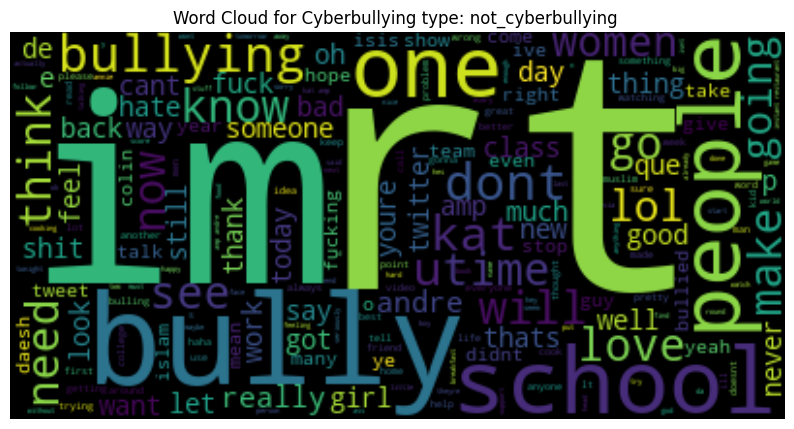

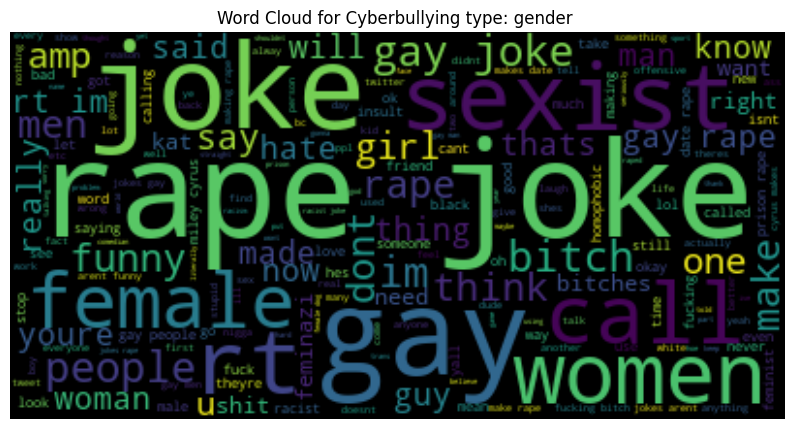

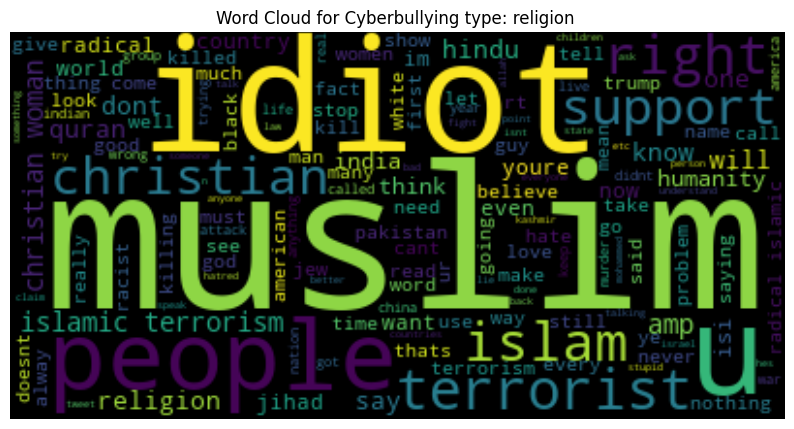

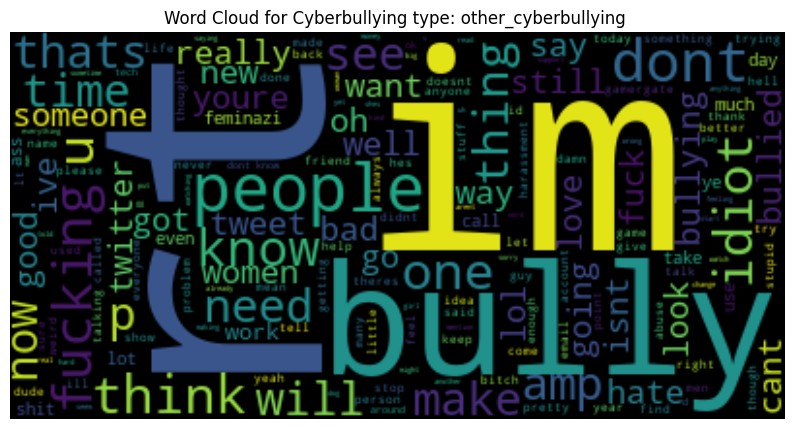

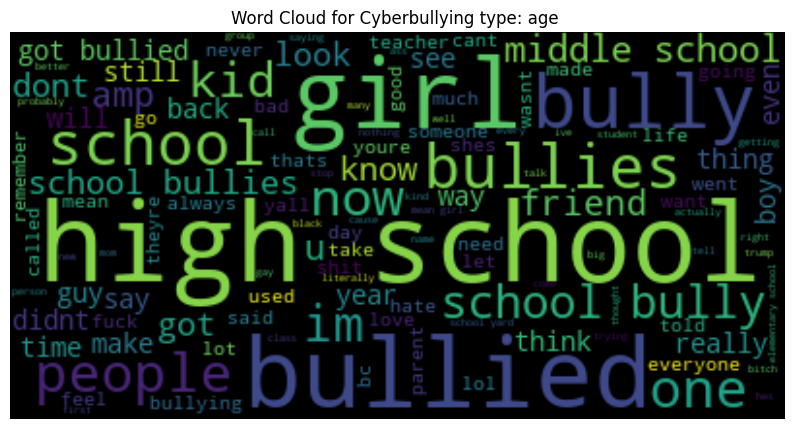

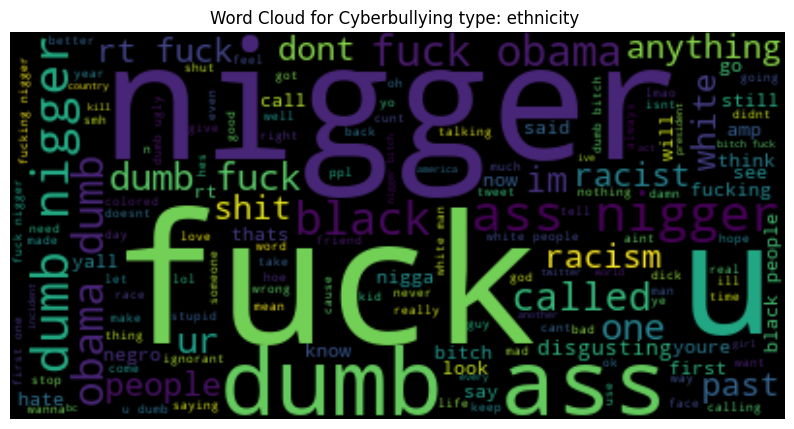

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get unique cyberbullying types
cyberbullying_types = df['cyberbullying_type'].unique()

# Generate and display a word cloud for each type
for cb_type in cyberbullying_types:
    # Filter the dataset for the current type
    subset = df[df['cyberbullying_type'] == cb_type]
    text = " ".join(tweet for tweet in subset.cleaned_tweet_text_without_hashtags)

    # Generate wordcloud
    wordcloud = WordCloud().generate(text)

    # Display the wordcloud
    plt.figure(figsize = (10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cyberbullying type: {cb_type} ")
    plt.show()


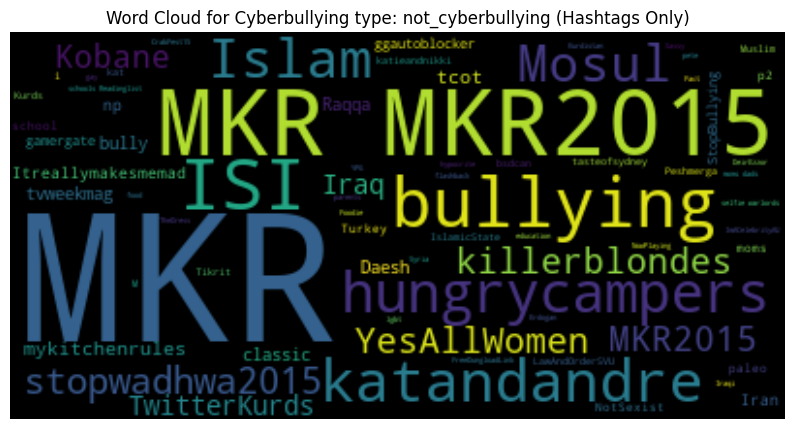

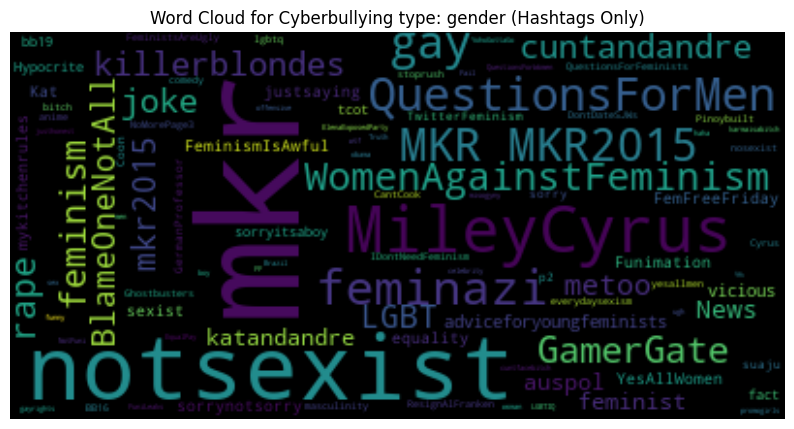

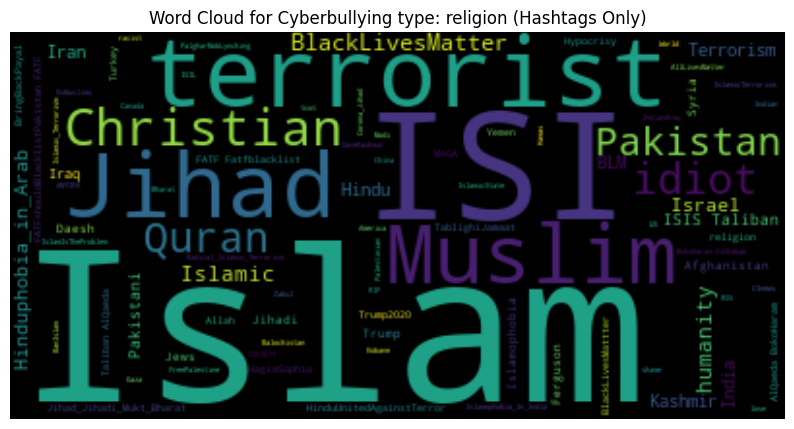

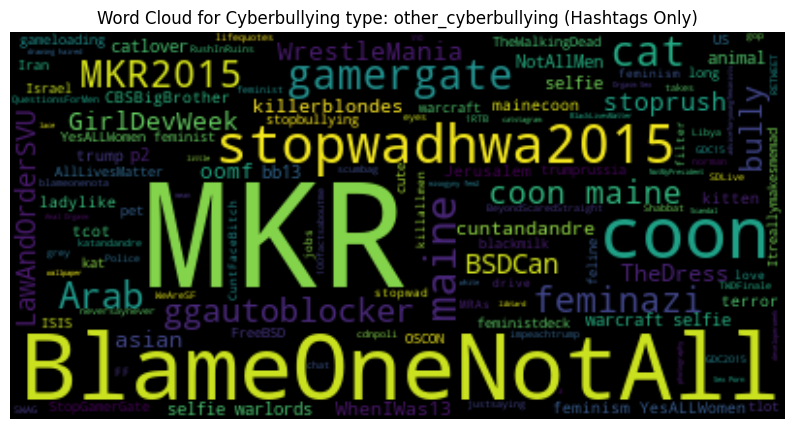

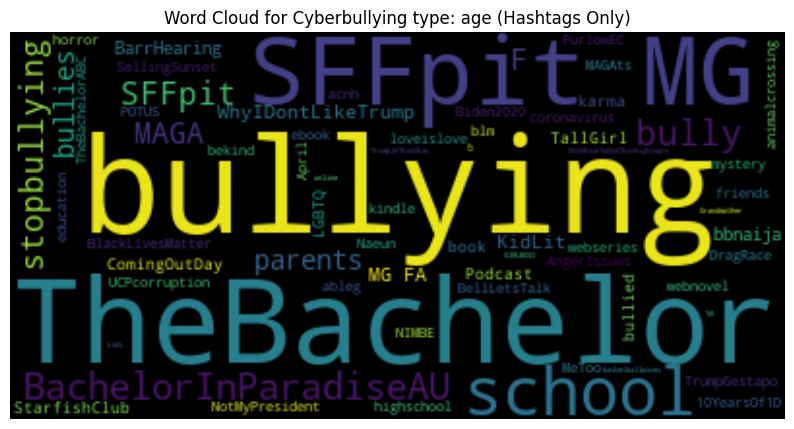

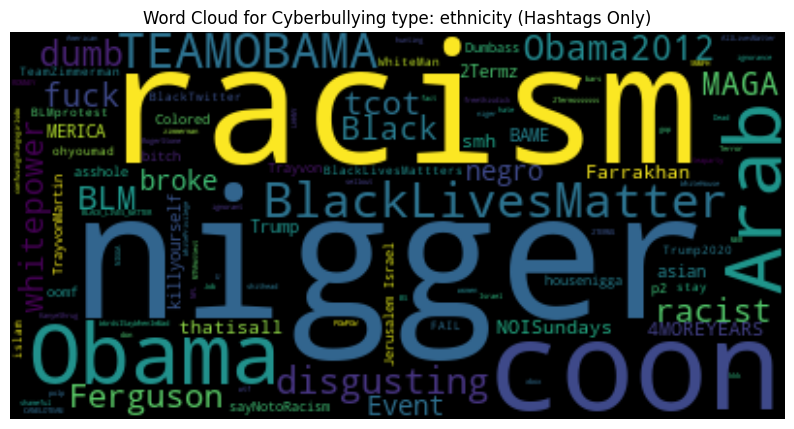

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get unique cyberbullying types
cyberbullying_types = df['cyberbullying_type'].unique()

# Generate and display a word cloud for each type
for cb_type in cyberbullying_types:
    # Filter the dataset for the current type
    subset = df[df['cyberbullying_type'] == cb_type]
    text = " ".join(tweet for tweet in subset.hashtags_only)

    # Generate wordcloud
    wordcloud = WordCloud().generate(text)

    # Display the wordcloud
    plt.figure(figsize = (10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cyberbullying type: {cb_type} (Hashtags Only)")
    plt.show()


## 6. Sentiment Analysis
Let's add an additional column that assigns sentiment polarity using TextBlob. Here, a negative polarity indicates negative sentiment and positive polarity indicates positive sentiment (the range is from -1 to 1). This may be useful for later classification.

In [11]:
from textblob import TextBlob

def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    # Return the polarity
    return analysis.sentiment.polarity

# Apply the sentiment analysis function to the cleaned tweets without hashtags
df['sentiment'] = df['cleaned_tweet_text_without_hashtags'].apply(analyze_sentiment)

# Display the DataFrame to verify the changes
df[['cleaned_tweet_text_without_hashtags', 'sentiment']].head(20)

,cleaned_tweet_text_without_hashtags,sentiment
0,in other words your food was crapilicious,-0.125000
1,why is so white,0.000000
2,a classy whore or more red velvet cupcakes,0.200000
3,meh p thanks for the heads up but not too concerned about another angry dude on twitter,-0.150000
4,this is an isis account pretending to be a kurdish account like islam it is all lies,0.000000
5,yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence,-0.050000
6,itu sekolah ya bukan tempat bully ga jauh kaya neraka,0.000000
7,karma i hope it bites kat on the butt she is just nasty,-1.000000
8,everything but mostly my priest,0.500000
9,rebecca black drops out of school due to bullying,-0.145833


In [13]:
# Calculate the average sentiment for each cyberbullying type and sort from worst to best
average_sentiment_by_type = df.groupby('cyberbullying_type')['sentiment'].mean().sort_values()

# Display the sorted average sentiment
average_sentiment_by_type


cyberbullying_type
ethnicity             -0.202576
religion              -0.083310
other_cyberbullying   -0.057656
not_cyberbullying      0.034808
age                    0.055548
gender                 0.073051
Name: sentiment, dtype: float64

Interestingly, age and gender bullying have sentiment polarities that appear to be more positive than "not_cyberbullying". Let's take a look at a few of these tweets.

In [14]:
# Filter for 'age' cyberbullying type and sort by sentiment in descending order
age_tweets_sorted = df[df['cyberbullying_type'] == 'age'].sort_values(by='sentiment', ascending=False)

# Display the top 5 tweets with the highest positive sentiment for 'age' bullying
age_tweets_sorted[['tweet_text', 'sentiment']].head(5)


,tweet_text,sentiment
34425,"Nimbe was a very brilliant student, in fact he's one of the best students in his class. But then, his class mates bullies him. So, Nimbe had to deal with his family issues caused by his father at home and bullies at school.",1.0
33532,-The Best Ever-,1.0
36546,Me: *stayed up all night thinking of the perfect thing to say to bully at school* Bully at school: hey weirdo Also me:,1.0
35781,It's almost as if these people were bullies at school and found the perfect job to continue doing so,1.0
32751,"i want shawn as my brother, boyfriend, sugar daddy, best friend, cat sitter, bully, schools nerd.",1.0


In [15]:
# Filter for 'gender' cyberbullying type and sort by sentiment in descending order
age_tweets_sorted = df[df['cyberbullying_type'] == 'gender'].sort_values(by='sentiment', ascending=False)

# Display the top 5 tweets with the highest positive sentiment for 'gender' bullying
age_tweets_sorted[['tweet_text', 'sentiment']].head(5)

,tweet_text,sentiment
8476,".""@DustyPee: #cuntandandre Best thing I've heard! #mkr”",1.0
8747,@mykitchenrules @bjtqld: #mkr2015 #mkr I think Kat thinks she is the best chef ever. Ah hello no,1.0
9197,RT @WendyMcElroy1: Cathy Young's @CathyYoung63 article on the Columbia U. rape accusation and mattress carrying is superb. Must read. http:…,1.0
13435,RT @bjtqld: @mykitchenrules @bjtqld: #mkr2015 #mkr I think Kat thinks she is the best chef ever. Ah hello no,1.0
11999,@LBigmann Best meme ever. Yours? Or where did you find it?,1.0


In [16]:
# Comment on the above. Definitely seems like a limitation of this dataset that it lacks the context of surrounding tweets.
# For example, "@The_Loki_Jotunn Awesome." is the entirety of a tweet that's labeled as age bullying. Without context though, it's not very meaningful.

# 7. Data Preprocess for Naive Bayes





In this step we tried to facilitate the training of a Naive Bayes classifier for detecting instances of cyberbullying within a dataset of tweets. In the dataset, each tweet is associated with a type of cyberbullying, categorized under columns such as 'gender', 'religion', 'age', 'ethnicity', etc.


We determine in an if/else condition if the tweet contains any of the bullying types in types_of_bullying. If it contains then the condition returns 1 indicating it is cyberbullying, if not it returns 0 indicating it is not a cyberbullying tweet.





In [6]:
# Encoding
def condition(bullying_type):
    types_of_bullying = [
      'gender',
      'religion',
      'other_cyberbullying',
      'age',
      'ethnicity'
    ]
    if bullying_type not in types_of_bullying:
      return 0
    else:
      return 1

df['bully_status'] = df['cyberbullying_type'].apply(lambda bullying_type: condition(bullying_type))

To verify the effectiveness of our labeling function, we've isolated the tweets identified as instances of cyberbullying by applying a filter on the bully_status column. We have filtered conditions that bully_status are True (1) which means they are bully_tweets.

In [9]:
bully_tweets = df[df['bully_status'] == True].sort_values(by='bully_status', ascending=False)

In [10]:
bully_tweets[['cyberbullying_type','tweet_text', 'bully_status']].head(5)

,cyberbullying_type,tweet_text,bully_status
7945,gender,rape is real..zvasiyana nema jokes about being...,1
34446,age,I honestly wish I knew. It feels like middle S...,1
34439,age,Ban private schools really means ban Christ fr...,1
34440,age,"a bully by his middle school teachers, peers o...",1
34441,age,randomly ended up creeping on the girls’ who b...,1


We have filtered conditions that bully_status is false (0) which means the tweets are not bullying tweets, to better check the effectivenes.

In [11]:
not_bully_tweets = df[df['bully_status'] == False].sort_values(by='bully_status', ascending=True)

In [12]:
not_bully_tweets[['cyberbullying_type','cleaned_tweet_text_with_hashtags', 'bully_status']].head(5)

,cyberbullying_type,cleaned_tweet_text_with_hashtags,bully_status
0,not_cyberbullying,in other words katandandre your food was crapi...,0
5303,not_cyberbullying,most of those people would be hard pressed to ...,0
5302,not_cyberbullying,rt i imagine you as a super heroine who saves ...,0
5301,not_cyberbullying,don t excuse your bad cooking annie mkr and th...,0
5300,not_cyberbullying,no she s not,0



We initialized a TF-IDF Vectorizer to convert the text data from the tweet_text column into a numerical format with a maximum of 1000 unique words, excluding common English stop words such as me, we, our, i, etc. We have printed a more detailed example of it down below.


It then applies this vectorizer to create a matrix of TF-IDF features, which is essential for training text-based machine learning models.

In [22]:
print(stopwords.words('english')[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [13]:
# Feature Extraction for 'tweet_text'
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=1000)
tweetText = tfidf_vectorizer.fit_transform(df['tweet_text'])

In [15]:
# Converting the status just in case to not encounter with an error while we train the model

cv = CountVectorizer()

tweetText = cv.fit_transform(df['cleaned_tweet_text_without_hashtags'])
status = df['bully_status'].astype(int)

In [24]:
# We're splitting the data as train and testing for Naive Bayes classification
trainText, testText, trainStatus, testStatus = train_test_split(tweetText, status, test_size=0.20, random_state=42)

To check and see the status of train and test datasets.

In [41]:
trainStatus.head()

27942    1
13988    1
30197    1
47342    1
43358    1
Name: bully_status, dtype: int64

In [42]:
testStatus.head()

40362    1
15019    1
46321    1
23927    1
1640     0
Name: bully_status, dtype: int64

In [25]:
# Training the Model
classifier = MultinomialNB()
classifier.fit(trainText, trainStatus)

: 

In [67]:
# Evaluating the Model
testPrediction = classifier.predict(testText)
print("Accuracy:", accuracy_score(testStatus, testPrediction))
print("\nClassification Report:\n", classification_report(testStatus, testPrediction))

Accuracy: 0.8513471013733096

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.25      0.36      1624
           1       0.86      0.98      0.92      7915

    accuracy                           0.85      9539
   macro avg       0.77      0.61      0.64      9539
weighted avg       0.83      0.85      0.82      9539



In [30]:
predicted_tweets = tfidf_vectorizer.inverse_transform(testText)

In [31]:
def collapse_tweets(arr):
  tweets = []
  for x in arr:
    tweet = ''
    for y in x:
      tweet = tweet + ' ' + y
    tweets.append(tweet)
  return tweets

tweets = collapse_tweets(predicted_tweets)
df_predictions = pd.DataFrame({'tweets': tweets, 'predictions': testPrediction})

df_predictions.head(50)

,tweets,predictions
0,nigger dumb tweets hahaha nigga amp fuck even,1
1,huh throw house face mkr2015 rt kat mkr,0
2,nigger throw act lives joke making care absolutely friends saying please tweet disgusting fuck see would call people black food,1
3,front open rt co http,1
4,look mkr,1
5,negro meaning nothing race called group full worry racist way kid 20 year funny thing really kids know last another white,1
6,niggers dumb way fuck real,1
7,mental insult rape jokes suicide racism sexism things gay self hate,1
8,happens middle care high said made everyone bullied sure sorry thing happened girls people school,1
9,brother lesbian rape straight jokes cuz choice literally playing guy haha said made watch also ass gay big disgusting like,1


Saving the trained model

In [32]:
import pickle

In [55]:
file = 'bullying_model2.sav'
pickle.dump(classifier, open(file, 'wb'))

In [45]:
#df to csv
df.to_csv('bullying_tweets.csv', index=False)

In [56]:
loaded_model = pickle.load(open(file, 'rb'))

In [57]:
# Find prediction 0 tweet from the df_predictions
df_predictions[df_predictions['predictions'] == 0].head(50)

,tweets,predictions
1,huh throw house face mkr2015 rt kat mkr,0
25,minutes watch bit mkr,0
41,bullying,0
43,bullying,0
62,bit ass oh kat mkr,0
82,que bullying,0
91,co http,0
97,days left lt gt co http,0
108,pass face seriously look cook go want last hope good mkr,0
109,start days week morning happy great well,0


In [60]:
input = ['needs stop bullying', 'happy morning', 'looking fat', 'you are so ugly', 'so beautiful', 'you are so stupid', 'heart means love bullying bully']
input_data = tfidf_vectorizer.transform(input)

prediction = loaded_model.predict(input_data)

In [61]:
print(prediction)

[0 0 1 1 1 1 0]
